In [409]:
import ale_py
import shimmy
import gymnasium as gym
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import os
import random
import copy
import time
import pickle
import torcheck


# NN

In [410]:

class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.training = False
        
        
        self.convStack = torch.nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0))
        
        self.linStack = torch.nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        x = self.convStack(x)
        if self.training:
            x = torch.flatten(x, start_dim = 1)
        if not self.training:
            x = torch.flatten(x, start_dim = 0)
        x = self.linStack(x)
        return x


# Agent

In [417]:
class DQN_agent:

    def __init__(self):
        # Get cpu, gpu or mps device for training.
        self.device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )
        print(f"Using {self.device} device")
        self.pred_NN = CNN().to(self.device)
        self.target_NN = copy.deepcopy(self.pred_NN)
    
    def predict(self, x):
        pred = self.NN_pred.forward(x)
        return pred
    
    def action(self, pred):
        if random.random() < epsilon:
            action = random.randint(0, pred.size(dim=0) - 1)
        else: 
            action = torch.argmax(pred)
        return action
    
    def train(self, experiences):
      
        data_set = ExperiencesDataset(experiences, self)
        data_loader = DataLoader(data_set, batch_size=samples_per_batch, shuffle=True)
        optimizer = torch.optim.SGD(self.pred_NN.parameters(), lr=0.1)
        loss_fn = nn.MSELoss()
        epoch_loss = 0
        
        self.pred_NN.train()
        self.pred_NN.training = True
        torcheck.register(optimizer)
        torcheck.add_module_changing_check(self.pred_NN, module_name="my_model")
        
        for batch, (state, y) in enumerate(data_loader):
            
            pred = self.pred_NN(state)
            loss = loss_fn(pred, y)
            
            loss.backward(retain_graph=True)
            optimizer.step()
            epoch_loss += loss.item()
            optimizer.zero_grad()
            
            if batch == (len(data_loader) - 1):
                self.pred_NN.train(mode=False)
                self.pred_NN.training = False
                return epoch_loss
        
    def copy(self):
        self.target_NN = copy.deepcopy(self.pred_NN)
        

# Dataset

In [418]:
class ExperiencesDataset(Dataset):
    
    def __init__(self, experiences, agent):
    
        #self.predictions = torch.empty(len(experiences), 5)
        self.states = []
        self.labels = torch.empty(len(experiences), 5)
        
        for n, experience in enumerate(experiences):
            state, action, reward, next_state = experience
            #pred = agent.pred_NN.forward(state)
            #self.predictions[n] = pred.detach().clone()   
            self.states.append(state)

            label = pred.detach().clone()
            label[action] = reward + gamma * max(agent.target_NN.forward(next_state))
            self.labels[n] = label    
            
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        return self.states[idx], self.labels[idx]

# Run agent (main)

Using cpu device


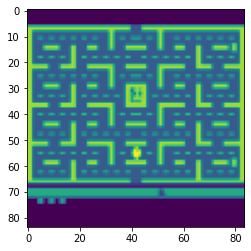

-----Training 1-----
Elapsed time: 6.609878301620483 seconds
loss:  tensor(0.0300, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0206, grad_fn=<MseLossBackward0>)
loss:  tensor(0.1026, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0450, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0368, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0323, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0446, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0522, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0877, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0328, grad_fn=<MseLossBackward0>)
Epoch loss:  0.4844400826841593 

-----Training 2-----
Elapsed time: 46.593875885009766 seconds
loss:  tensor(1.7846, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0321, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0516, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0475, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0591, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0507, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0822, grad_fn=<MseLossBackw

In [ ]:
import matplotlib.pyplot as plt
#initialize environment
env = gym.make("ALE/Pacman-v5",render_mode="rgb_array")
#preprocess environment
env = gym.wrappers.AtariPreprocessing(env, screen_size=84, grayscale_obs=True, frame_skip=1, noop_max=30, scale_obs = True)
#start environment
state, info = env.reset()

#hyperparams
epsilon = 1
epsilon_decay = 0.9
gamma = 0.75
experience_capacity = 10000
training_freq = 1000
copying_freq = 2000
samples_per_training_session = 500
samples_per_batch = 50

#initialize agent
agent = DQN_agent()

#load saved model to agent NNs
#agent.pred_NN.load_state_dict(torch.load("model"))
#agent.target_NN = copy.deepcopy(agent.pred_NN)

#select first action
action = random.randint(0, 4)

#get first states
state1, reward, terminated, truncated, info = env.step(action)
state2, reward, terminated, truncated, info = env.step(action)
state3, reward, terminated, truncated, info = env.step(action)
state4, reward, terminated, truncated, info = env.step(action)

#convert first states to correct datatype and stack
state1 = TF.to_tensor(state1)     
state2 = TF.to_tensor(state2)
state3 = TF.to_tensor(state3)
state4 = TF.to_tensor(state4)
state_stack =torch.cat((state1,state2,state3,state4))

#plot image, to se resolution
img = state4.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.show()

#timer and variables connected to time
start_time = time.time()
epsilon_start_time = time.time()
elapsed_time = 0
max_time = 40000
training_time = 0
decay_freq = max_time/16

#for logging
training_session = 0

#loops until max_time is reached
while elapsed_time < max_time:
    experiences = []
    
    #loops until experience_capacity is reached
    for i in range(1, experience_capacity):
        
    
        #predict q-values and choose action
        pred = agent.pred_NN.forward(state_stack)
        action = agent.action(pred)
        
        #get next states
        next_state1, reward1, terminated, truncated, info = env.step(action)
        next_state2, reward2, terminated, truncated, info = env.step(action)
        next_state3, reward3, terminated, truncated, info = env.step(action)
        next_state4, reward4, terminated, truncated, info = env.step(action)

        #if pac-man dies 4 times, reset and start again
        if terminated or truncated: 
            #restart pacman
            env.reset()
            #select first action
            action = random.randint(0, 4)
            #get first states
            next_state1, reward1, terminated, truncated, info = env.step(action)
            next_state2, reward2, terminated, truncated, info = env.step(action)
            next_state3, reward3, terminated, truncated, info = env.step(action)
            next_state4, reward4, terminated, truncated, info = env.step(action)
            
        #convert next state to correct type and stack
        next_state1 = TF.to_tensor(next_state1)
        next_state2 = TF.to_tensor(next_state2)
        next_state3 = TF.to_tensor(next_state3)
        next_state4 = TF.to_tensor(next_state4)
        next_state_stack = torch.cat((next_state1,next_state2,next_state3,next_state4))
        
        #sum rewards 
        tot_reward = 0
        tot_reward = reward1 + reward2 + reward3 + reward4
        
        #add to experiences
        save_this = [state_stack, action, tot_reward, next_state_stack] 
        experiences.append(save_this)
        
        #train
        if i % training_freq == 0:
            training_session += 1
            print(f'-----Training {training_session}-----')
            elapsed_time = time.time() - start_time
            print(f'Elapsed time: {elapsed_time} seconds')
            experiences_train = random.choices(experiences, k=samples_per_training_session)
            epoch_loss = agent.train(experiences_train)
            print("Epoch loss: ", epoch_loss, "\n")  
        
        #copy
        if i % copying_freq == 0:
            print('-----Copying pred_NN to target_NN-----\n')
            agent.copy()
            elapsed_time = time.time() - start_time
            if elapsed_time > max_time:
                break
        #next state stack becomes current state stack
        state_stack = next_state_stack
            
        
    #decay epsilon
    if(epsilon > 0.2 and (time.time() - epsilon_start_time) > decay_freq):
        print(f'------Epsilon decays after {(time.time() - epsilon_start_time)} seconds since last decay-----')
        print(f'old epsilon: {epsilon}')
        epsilon = epsilon * epsilon_decay 
        print(f'new epsilon: {epsilon}\n')
        epsilon_start_time = time.time()
    
        

print(f'*****stopped training after {elapsed_time} seconds*****\n')
print('*****Pickle Dumping model*****\n')

file = open('safetyPickleDump', 'wb')
pickle.dump(agent, file)
file.close()

print("*****Saving model*****")
torch.save(agent.pred_NN.state_dict(), "model")

env.close()